IMPORTAÇÃO DAS DEPENDÊNCIAS

In [1]:
import pandas as pd
import numpy as np
from pandas.plotting import table
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import scipy.stats as stats
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import mean_squared_error
# import statsmodels as sm
# import statsmodels.formula.api as smf

CRIAÇÃO DO DATAFRAME df_geral

In [2]:
df_geral = pd.read_csv("clear-data/dados_tratados_2024.csv")

CONVERSÃO DE DADOS REFERENTES À DATA E HORA

In [3]:
df_geral['data_hora'] = pd.to_datetime(df_geral['data_hora'])

df_geral['date'] = df_geral['data_hora'].dt.date

In [4]:
tabela_horarios = pd.read_excel("bcw-operation-calendar.xlsx")
tabela_horarios["date"] = pd.to_datetime(tabela_horarios["date"])

In [5]:
# Cálculo dos percentis
p5 = 0
p90 = 0
p95 = 0

# Função de mapeamento de cores
def custom_color_map(value):
    if value > p95:
        return 'black'
    else:
        norm_value = (value - p5) / (p95 - p5)
        return plt.cm.RdYlGn_r(norm_value)

def gera_calendario(espera, tipo, metrica, mes):
    # Reorganize o dataframe para a forma desejada
    pivot_df = espera.pivot_table(values='wait_time', index='week_of_year', columns='day_of_week', aggfunc=np.mean)

    # Reordene as colunas para começar na segunda-feira
    ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Crie um DataFrame temporário com todas as colunas ordenadas
    temp_df = pd.DataFrame(columns=ordered_days)
    
    for day in ordered_days:
        if day in pivot_df.columns:
            temp_df[day] = pivot_df[day]
        else:
            temp_df[day] = np.nan

    pivot_df = temp_df

    # Passo 1: Crie uma matriz de anotações
    annotation_array = []
    for week in pivot_df.index:
        annotation_row = []
        for day in ordered_days:
            date_row = espera[(espera['week_of_year'] == week) & (espera['day_of_week'] == day)]
            if not date_row.empty:
                day_of_month = date_row.iloc[0]['day']
                month = date_row.iloc[0]['month']
                wait_time = date_row.iloc[0]['wait_time']
                annotation_row.append(f"{day_of_month}/{month}\n{wait_time}")
            else:
                annotation_row.append('')
        annotation_array.append(annotation_row)

    annotation_array = np.array(annotation_array)
    
    # Inverter o DataFrame e a matriz de anotações
    pivot_df_inverted = pivot_df.iloc[::-1]
    annotation_array_inverted = annotation_array[::-1]

    altura = 0

    if tipo =='Mensal':
        altura = 10
    else:
        altura = 30
    
    plt.figure(figsize=(12, altura))

    # Anotação e cores
    for i, week in enumerate(pivot_df_inverted.index):
        for j, day in enumerate(pivot_df_inverted.columns):
            value = pivot_df_inverted.loc[week, day]
            if not np.isnan(value):
                color = 'white' if value > p90 or value < 17 else 'black'
                
                # A data acima do tempo médio de fila (fonte menor e sem negrito)
                day_of_month = annotation_array_inverted[i, j].split('\n')[0]
                plt.text(j + 0.8, i + 0.8, f"{day_of_month}", ha='center', va='center', fontsize=10, fontweight='normal', color=color)

                # O tempo médio de fila (fonte maior e negrito)
                wait_time = annotation_array_inverted[i, j].split('\n')[1]
                wait_time = int(float(wait_time))  # Converter para float e, em seguida, para inteiro
            
                plt.text(j + 0.5, i + 0.4, f"{wait_time}", ha='center', va='center', fontsize=18, fontweight='bold', color=color)

                plt.fill_betweenx([i, i+1], j, j+1, color=custom_color_map(value))
                plt.plot([j, j+1, j+1, j, j], [i, i, i+1, i+1, i], color='white', linewidth=1.5)

    plt.xticks(ticks=np.arange(0.5, len(pivot_df_inverted.columns)), labels=pivot_df_inverted.columns, rotation=45)
    plt.yticks(ticks=np.arange(0.5, len(pivot_df_inverted.index)), labels=pivot_df_inverted.index)
    titulo = ""
    
    if metrica == 'mean':
        titulo = "Calendário de Tempo de Espera Médio"
    elif metrica == 'max':
        titulo = "Calendário de Tempo de Espera Máximo"
    elif metrica == 'median':
        titulo = "Calendário de Tempo de Espera Mediano"
    elif metrica == 'mode':
        titulo = "Calendário de Tempo de Espera Modal"
    elif metrica == 'std':
        titulo = "Calendário dos Desvios Padrão do Tempo de Espera"
    
    plt.title(titulo)
    plt.xlabel("Dia da Semana")
    plt.ylabel("Semana do Ano")

    now = datetime.now()
    data_hora_formatada = now.strftime('%Y-%m-%d-%H%M')

    nome_arquivo = ''
    
    if tipo == 'Mensal':
        nome_arquivo=f'{metrica}_daily_wait_time_{mes}2024-{data_hora_formatada}.png'
    else:
        nome_arquivo=f'{metrica}_daily_wait_time_2024-{data_hora_formatada}.png'

    plt.savefig(nome_arquivo)

    plt.show()

### ANÁLISE BASEADA NOS TEMPOS MÉDIOS DE FILA

In [6]:
espera_media = df_geral.groupby('date')['wait_time'].mean().reset_index()

In [7]:
espera_media['wait_time'] = espera_media['wait_time'].round(0)

In [8]:
espera_media['date'] = pd.to_datetime(espera_media['date'])
espera_media['year'] = espera_media['date'].dt.year
espera_media['month'] = espera_media['date'].dt.month
espera_media['day'] = espera_media['date'].dt.day

In [9]:
espera_media = pd.merge(espera_media, tabela_horarios, on="date", how="left")

# Adicione colunas para o dia da semana e a semana do ano
espera_media['day_of_week'] = espera_media['date'].dt.day_name()
espera_media['week_of_year'] = espera_media['date'].dt.isocalendar().week

# Identifique os registros que atendem ao critério
primeiros_dias_janeiro = (espera_media['month'] == 1) & (espera_media['week_of_year'] > 50)

# Atribua o valor 0 à coluna 'week_of_year' para esses registros
espera_media.loc[primeiros_dias_janeiro, 'week_of_year'] = 0

espera_media

,date,wait_time,year,month,day,day_of_the_week,park_open,park_opening_time,park_closing_time,sale,...,Madagascar 1600,Madagascar 1700,Sonho 1800,Excalibur 1200,Excalibur 1430,Excalibur 1700,Shrek 1900,Trolls 1900,day_of_week,week_of_year
0,2024-01-01,47.0,2024,1,1,monday,True,10:00:00,19:00:00,NaN,...,True,True,True,True,False,False,True,False,Monday,1
1,2024-01-02,16.0,2024,1,2,tuesday,True,10:00:00,19:00:00,NaN,...,True,False,True,True,False,False,True,False,Tuesday,1
2,2024-01-03,20.0,2024,1,3,wednesday,True,10:00:00,19:00:00,NaN,...,True,True,True,True,True,True,True,False,Wednesday,1
3,2024-01-04,62.0,2024,1,4,thursday,True,10:00:00,19:00:00,NaN,...,True,True,True,True,True,True,True,False,Thursday,1
4,2024-01-05,42.0,2024,1,5,friday,True,10:00:00,19:00:00,NaN,...,True,True,True,True,True,False,True,False,Friday,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,2024-03-27,26.0,2024,3,27,wednesday,True,10:00:00,19:00:00,NaN,...,True,False,True,True,False,False,False,True,Wednesday,13
87,2024-03-28,31.0,2024,3,28,thursday,True,10:00:00,19:00:00,NaN,...,True,False,True,True,False,False,False,True,Thursday,13
88,2024-03-29,50.0,2024,3,29,friday,True,10:00:00,19:00:00,NaN,...,True,False,True,True,False,False,False,True,Friday,13
89,2024-03-30,55.0,2024,3,30,saturday,True,10:00:00,19:00:00,NaN,...,True,False,True,True,False,False,False,True,Saturday,13


In [10]:
# Reorganize o dataframe para a forma desejada
pivot_df = espera_media.pivot_table(values='wait_time', index='week_of_year', columns='day_of_week', aggfunc=np.mean)

# Reordene as colunas para começar na segunda-feira
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_df = pivot_df[ordered_days]

C:\Users\Luis PC\AppData\Local\Temp\ipykernel_9888\3200855438.py:2: FutureWarning: The provided callable <function mean at 0x00000189ACAE5300> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_df = espera_media.pivot_table(values='wait_time', index='week_of_year', columns='day_of_week', aggfunc=np.mean)


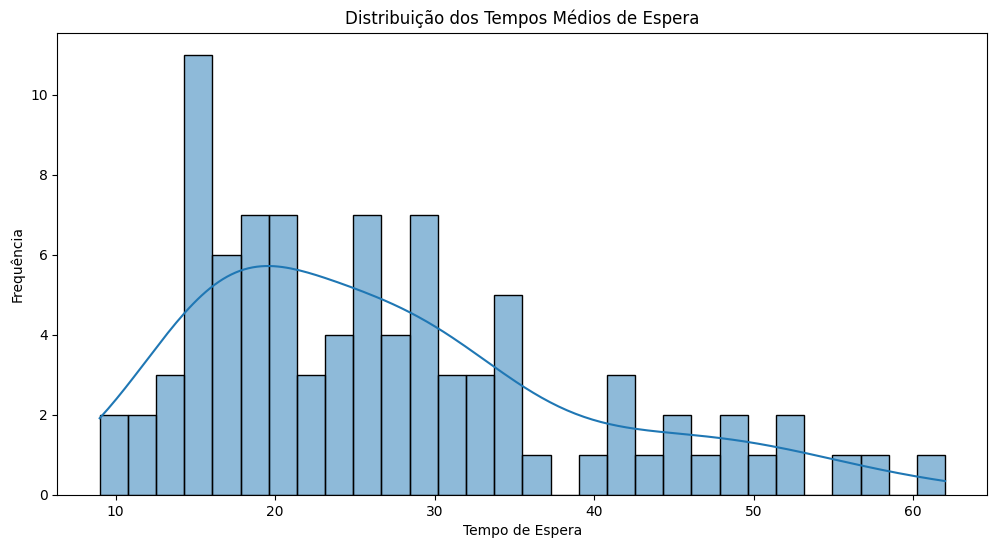

In [11]:
plt.figure(figsize=(12, 6))
sns.histplot(espera_media['wait_time'], bins=30, kde=True)
plt.title("Distribuição dos Tempos Médios de Espera")
plt.xlabel("Tempo de Espera")
plt.ylabel("Frequência")
plt.show()

In [12]:
meses = ['jan', 'fev', 'mar', 'abr', 'mai', 'jun', 'jul', 'ago', 'set', 'out', 'nov', 'dez']

espera_media_meses = []

for mes in meses:
    numero_mes = meses.index(mes) + 1  # Obtém o número do mês (janeiro = 1, fevereiro = 2, etc.)
    espera_media_mes = espera_media[espera_media['month'] == numero_mes]
    espera_media_meses.append(espera_media_mes)

In [13]:
# Cálculo dos percentis
p5 = np.percentile(espera_media['wait_time'], 5)
p90 = np.percentile(espera_media['wait_time'], 90)
p95 = np.percentile(espera_media['wait_time'], 95)

C:\Users\Luis PC\AppData\Local\Temp\ipykernel_9888\2413875904.py:16: FutureWarning: The provided callable <function mean at 0x00000189ACAE5300> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_df = espera.pivot_table(values='wait_time', index='week_of_year', columns='day_of_week', aggfunc=np.mean)


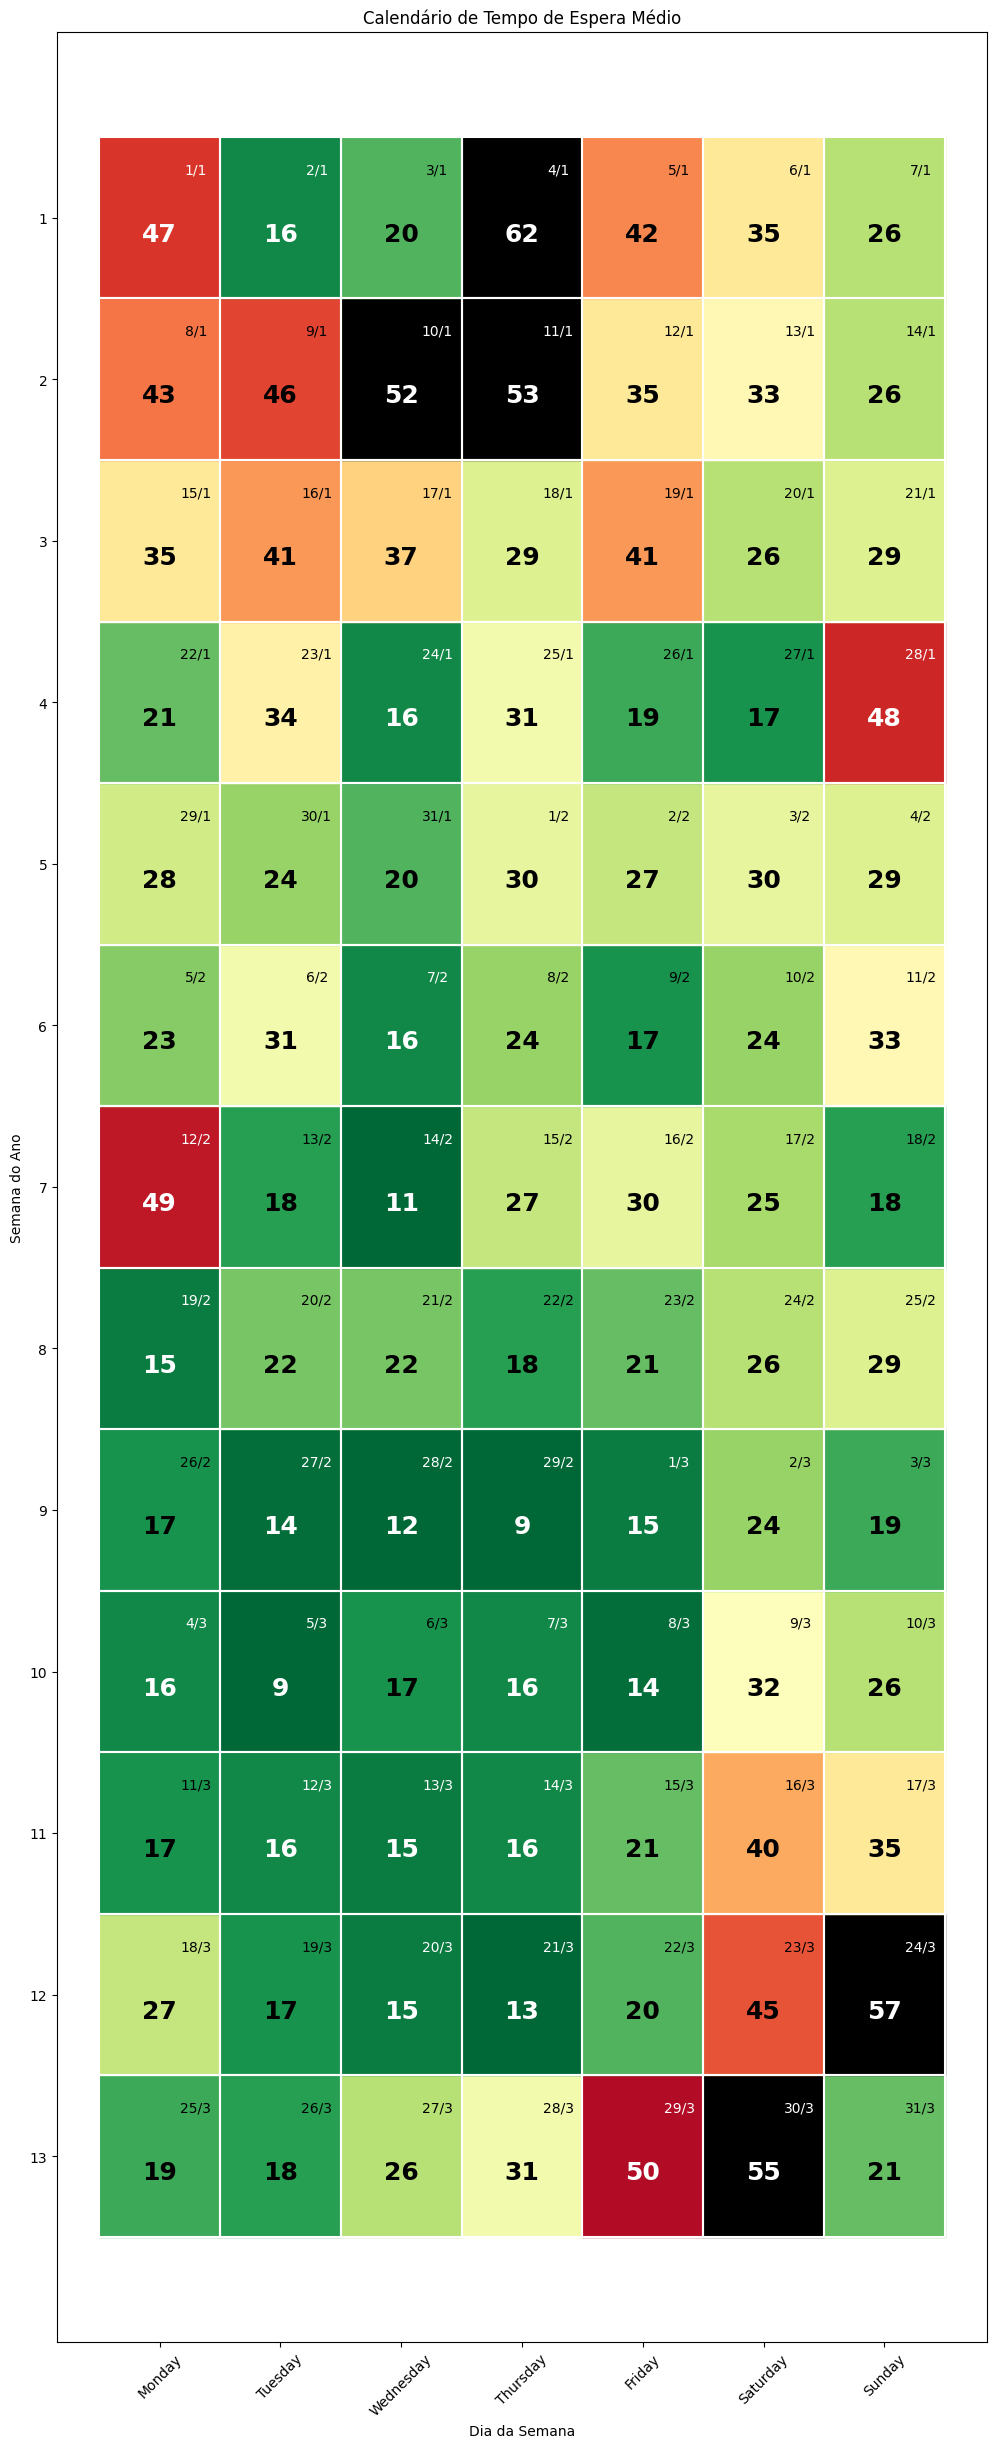

In [14]:
gera_calendario(espera_media, 'Anual', 'mean', '')

In [15]:
# for mes in meses:
#     numero_mes = meses.index(mes)
#     gera_calendario(espera_media_meses[numero_mes], 'Mensal', 'mean', mes)

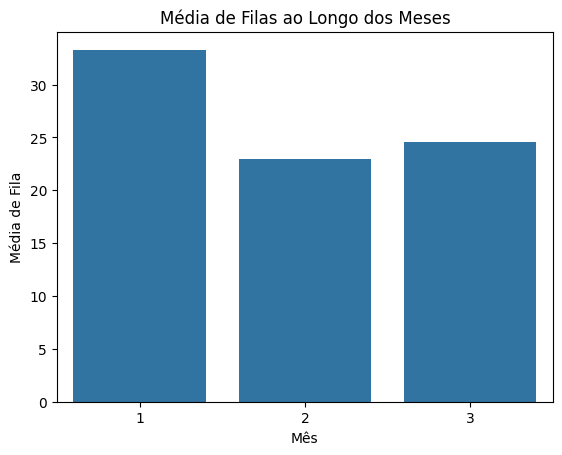

In [16]:
# Média de filas ao longo dos meses
media_mes = espera_media.groupby('month')['wait_time'].mean()

# Plotar gráfico de barras
sns.barplot(x=media_mes.index, y=media_mes.values)
plt.xlabel('Mês')
plt.ylabel('Média de Fila')
plt.title('Média de Filas ao Longo dos Meses')
plt.show()

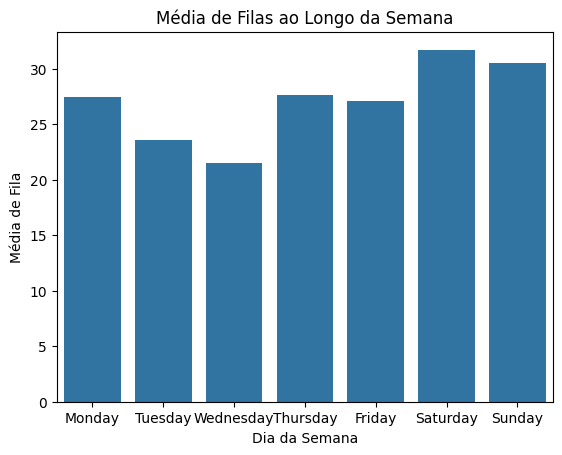

In [17]:
# Média de filas ao longo da semana
media_semana = espera_media.groupby('day_of_week')['wait_time'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plotar gráfico de barras
sns.barplot(x=media_semana.index, y=media_semana.values)
plt.xlabel('Dia da Semana')
plt.ylabel('Média de Fila')
plt.title('Média de Filas ao Longo da Semana')
plt.show()

### ANÁLISE BASEADA NOS TEMPOS MÁXIMOS DE FILA

In [18]:
espera_maxima = df_geral.groupby('date')['wait_time'].max().reset_index()

In [19]:
espera_maxima['wait_time'] = espera_maxima['wait_time'].round(0)

In [20]:
espera_maxima['date'] = pd.to_datetime(espera_maxima['date'])
espera_maxima['year'] = espera_maxima['date'].dt.year
espera_maxima['month'] = espera_maxima['date'].dt.month
espera_maxima['day'] = espera_maxima['date'].dt.day

In [21]:
espera_maxima = pd.merge(espera_maxima, tabela_horarios, on="date", how="left")

# Adicione colunas para o dia da semana e a semana do ano
espera_maxima['day_of_week'] = espera_maxima['date'].dt.day_name()
espera_maxima['week_of_year'] = espera_maxima['date'].dt.isocalendar().week

# Identifique os registros que atendem ao critério
primeiros_dias_janeiro = (espera_maxima['month'] == 1) & (espera_maxima['week_of_year'] > 50)

# Atribua o valor 0 à coluna 'week_of_year' para esses registros
espera_maxima.loc[primeiros_dias_janeiro, 'week_of_year'] = 0

espera_maxima

,date,wait_time,year,month,day,day_of_the_week,park_open,park_opening_time,park_closing_time,sale,...,Madagascar 1600,Madagascar 1700,Sonho 1800,Excalibur 1200,Excalibur 1430,Excalibur 1700,Shrek 1900,Trolls 1900,day_of_week,week_of_year
0,2024-01-01,180,2024,1,1,monday,True,10:00:00,19:00:00,NaN,...,True,True,True,True,False,False,True,False,Monday,1
1,2024-01-02,100,2024,1,2,tuesday,True,10:00:00,19:00:00,NaN,...,True,False,True,True,False,False,True,False,Tuesday,1
2,2024-01-03,180,2024,1,3,wednesday,True,10:00:00,19:00:00,NaN,...,True,True,True,True,True,True,True,False,Wednesday,1
3,2024-01-04,180,2024,1,4,thursday,True,10:00:00,19:00:00,NaN,...,True,True,True,True,True,True,True,False,Thursday,1
4,2024-01-05,180,2024,1,5,friday,True,10:00:00,19:00:00,NaN,...,True,True,True,True,True,False,True,False,Friday,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,2024-03-27,130,2024,3,27,wednesday,True,10:00:00,19:00:00,NaN,...,True,False,True,True,False,False,False,True,Wednesday,13
87,2024-03-28,180,2024,3,28,thursday,True,10:00:00,19:00:00,NaN,...,True,False,True,True,False,False,False,True,Thursday,13
88,2024-03-29,180,2024,3,29,friday,True,10:00:00,19:00:00,NaN,...,True,False,True,True,False,False,False,True,Friday,13
89,2024-03-30,180,2024,3,30,saturday,True,10:00:00,19:00:00,NaN,...,True,False,True,True,False,False,False,True,Saturday,13


In [22]:
# Reorganize o dataframe para a forma desejada
pivot_df = espera_maxima.pivot_table(values='wait_time', index='week_of_year', columns='day_of_week', aggfunc=np.mean)

# Reordene as colunas para começar na segunda-feira
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_df = pivot_df[ordered_days]

C:\Users\Luis PC\AppData\Local\Temp\ipykernel_9888\408293098.py:2: FutureWarning: The provided callable <function mean at 0x00000189ACAE5300> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_df = espera_maxima.pivot_table(values='wait_time', index='week_of_year', columns='day_of_week', aggfunc=np.mean)


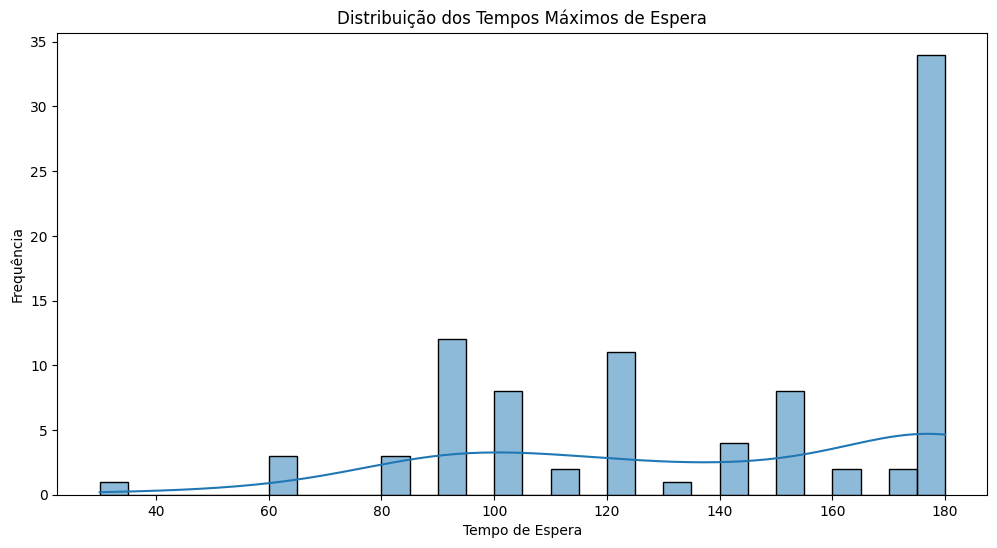

In [23]:
plt.figure(figsize=(12, 6))
sns.histplot(espera_maxima['wait_time'], bins=30, kde=True)
plt.title("Distribuição dos Tempos Máximos de Espera")
plt.xlabel("Tempo de Espera")
plt.ylabel("Frequência")
plt.show()

In [24]:
meses = ['jan', 'fev', 'mar', 'abr', 'mai', 'jun', 'jul', 'ago', 'set', 'out', 'nov', 'dez']

espera_maxima_meses = []

for mes in meses:
    numero_mes = meses.index(mes) + 1  # Obtém o número do mês (janeiro = 1, fevereiro = 2, etc.)
    espera_maxima_mes = espera_maxima[espera_maxima['month'] == numero_mes]
    espera_maxima_meses.append(espera_maxima_mes)

In [25]:
# Cálculo dos percentis
p5 = np.percentile(espera_maxima['wait_time'], 5)
p90 = np.percentile(espera_maxima['wait_time'], 90)
p95 = np.percentile(espera_maxima['wait_time'], 95)

C:\Users\Luis PC\AppData\Local\Temp\ipykernel_9888\2413875904.py:16: FutureWarning: The provided callable <function mean at 0x00000189ACAE5300> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_df = espera.pivot_table(values='wait_time', index='week_of_year', columns='day_of_week', aggfunc=np.mean)


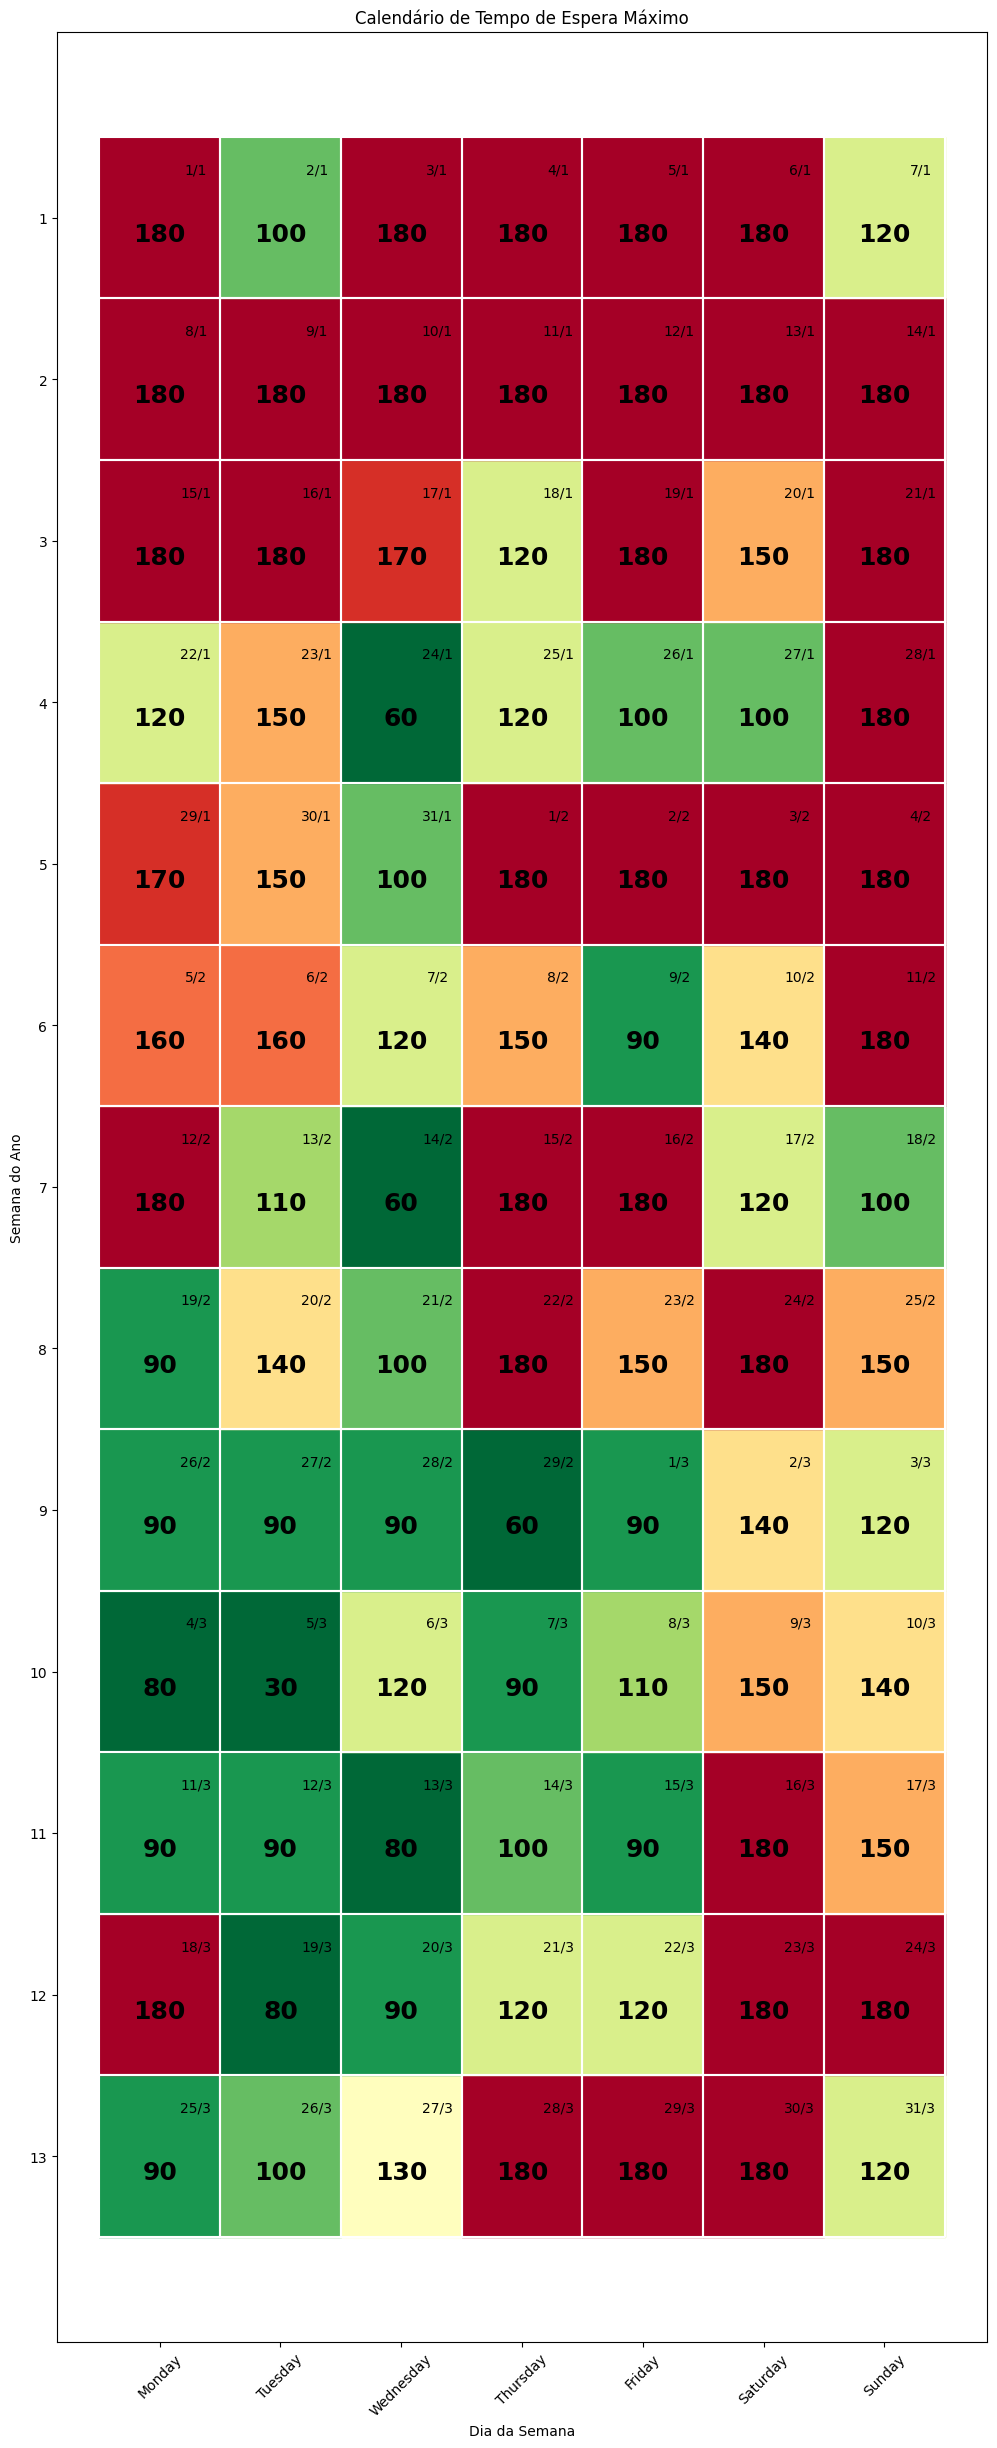

In [26]:
gera_calendario(espera_maxima, 'Anual', 'max', '')

In [27]:
# for mes in meses:
#     numero_mes = meses.index(mes)
#     gera_calendario(espera_maxima_meses[numero_mes], 'Mensal', 'max', mes)

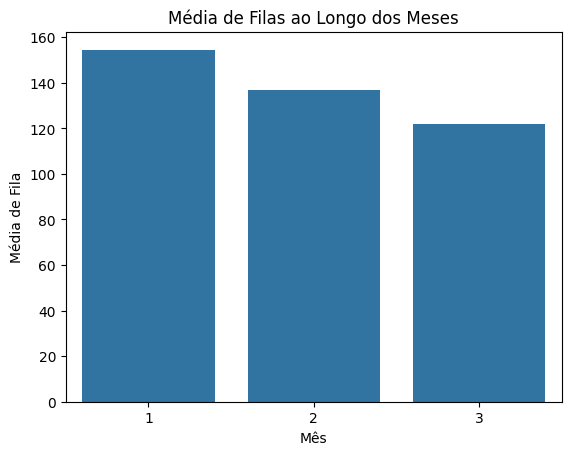

In [28]:
# Média dos tempos máximos de filas ao longo dos meses
media_mes = espera_maxima.groupby('month')['wait_time'].mean()

# Plotar gráfico de barras
sns.barplot(x=media_mes.index, y=media_mes.values)
plt.xlabel('Mês')
plt.ylabel('Média de Fila')
plt.title('Média de Filas ao Longo dos Meses')
plt.show()

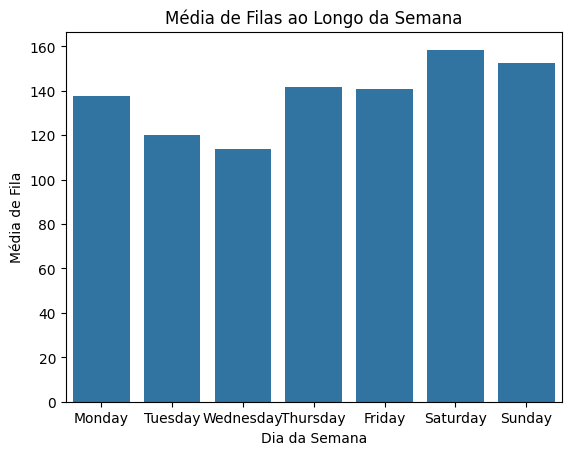

In [29]:
# Média de filas ao longo da semana
media_semana = espera_maxima.groupby('day_of_week')['wait_time'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plotar gráfico de barras
sns.barplot(x=media_semana.index, y=media_semana.values)
plt.xlabel('Dia da Semana')
plt.ylabel('Média de Fila')
plt.title('Média de Filas ao Longo da Semana')
plt.show()

### ANÁLISE BASEADA NA MEDIANA DOS TEMPOS DE FILA

In [30]:
espera_mediana = df_geral.groupby('date')['wait_time'].median().reset_index()

In [31]:
espera_mediana['wait_time'] = espera_mediana['wait_time'].round(0)

In [32]:
espera_mediana['date'] = pd.to_datetime(espera_mediana['date'])
espera_mediana['year'] = espera_mediana['date'].dt.year
espera_mediana['month'] = espera_mediana['date'].dt.month
espera_mediana['day'] = espera_mediana['date'].dt.day

In [33]:
espera_mediana = pd.merge(espera_mediana, tabela_horarios, on="date", how="left")

# Adicione colunas para o dia da semana e a semana do ano
espera_mediana['day_of_week'] = espera_mediana['date'].dt.day_name()
espera_mediana['week_of_year'] = espera_mediana['date'].dt.isocalendar().week

# Identifique os registros que atendem ao critério
primeiros_dias_janeiro = (espera_mediana['month'] == 1) & (espera_mediana['week_of_year'] > 50)

# Atribua o valor 0 à coluna 'week_of_year' para esses registros
espera_mediana.loc[primeiros_dias_janeiro, 'week_of_year'] = 0

espera_mediana

,date,wait_time,year,month,day,day_of_the_week,park_open,park_opening_time,park_closing_time,sale,...,Madagascar 1600,Madagascar 1700,Sonho 1800,Excalibur 1200,Excalibur 1430,Excalibur 1700,Shrek 1900,Trolls 1900,day_of_week,week_of_year
0,2024-01-01,40.0,2024,1,1,monday,True,10:00:00,19:00:00,NaN,...,True,True,True,True,False,False,True,False,Monday,1
1,2024-01-02,10.0,2024,1,2,tuesday,True,10:00:00,19:00:00,NaN,...,True,False,True,True,False,False,True,False,Tuesday,1
2,2024-01-03,15.0,2024,1,3,wednesday,True,10:00:00,19:00:00,NaN,...,True,True,True,True,True,True,True,False,Wednesday,1
3,2024-01-04,50.0,2024,1,4,thursday,True,10:00:00,19:00:00,NaN,...,True,True,True,True,True,True,True,False,Thursday,1
4,2024-01-05,30.0,2024,1,5,friday,True,10:00:00,19:00:00,NaN,...,True,True,True,True,True,False,True,False,Friday,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,2024-03-27,20.0,2024,3,27,wednesday,True,10:00:00,19:00:00,NaN,...,True,False,True,True,False,False,False,True,Wednesday,13
87,2024-03-28,20.0,2024,3,28,thursday,True,10:00:00,19:00:00,NaN,...,True,False,True,True,False,False,False,True,Thursday,13
88,2024-03-29,30.0,2024,3,29,friday,True,10:00:00,19:00:00,NaN,...,True,False,True,True,False,False,False,True,Friday,13
89,2024-03-30,40.0,2024,3,30,saturday,True,10:00:00,19:00:00,NaN,...,True,False,True,True,False,False,False,True,Saturday,13


In [34]:
# Reorganize o dataframe para a forma desejada
pivot_df = espera_mediana.pivot_table(values='wait_time', index='week_of_year', columns='day_of_week', aggfunc=np.mean)

# Reordene as colunas para começar na segunda-feira
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_df = pivot_df[ordered_days]

C:\Users\Luis PC\AppData\Local\Temp\ipykernel_9888\3275837030.py:2: FutureWarning: The provided callable <function mean at 0x00000189ACAE5300> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_df = espera_mediana.pivot_table(values='wait_time', index='week_of_year', columns='day_of_week', aggfunc=np.mean)


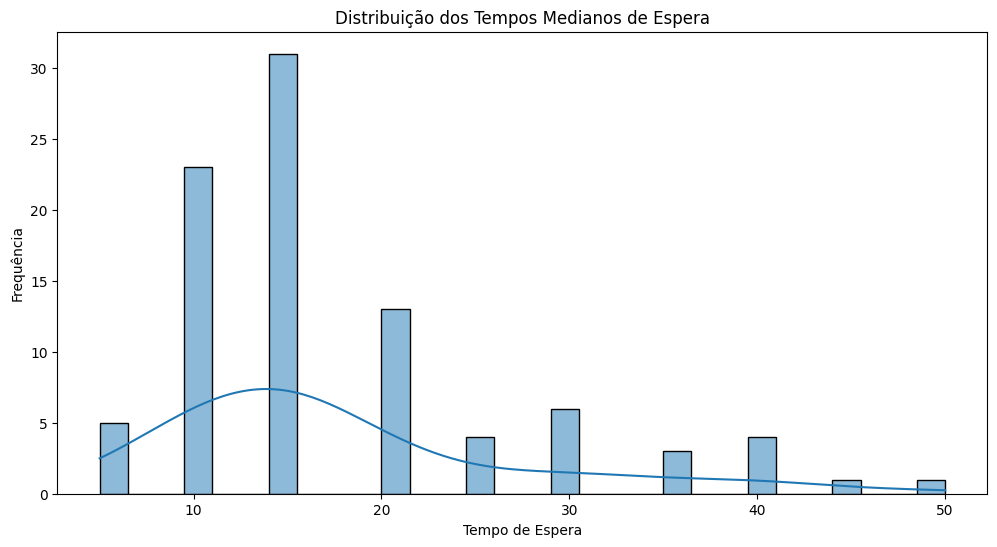

In [35]:
plt.figure(figsize=(12, 6))
sns.histplot(espera_mediana['wait_time'], bins=30, kde=True)
plt.title("Distribuição dos Tempos Medianos de Espera")
plt.xlabel("Tempo de Espera")
plt.ylabel("Frequência")
plt.show()

In [36]:
meses = ['jan', 'fev', 'mar', 'abr', 'mai', 'jun', 'jul', 'ago', 'set', 'out', 'nov', 'dez']

espera_mediana_meses = []

for mes in meses:
    numero_mes = meses.index(mes) + 1  # Obtém o número do mês (janeiro = 1, fevereiro = 2, etc.)
    espera_mediana_mes = espera_mediana[espera_mediana['month'] == numero_mes]
    espera_mediana_meses.append(espera_mediana_mes)

In [37]:
# Cálculo dos percentis
p5 = np.percentile(espera_mediana['wait_time'], 5)
p90 = np.percentile(espera_mediana['wait_time'], 90)
p95 = np.percentile(espera_mediana['wait_time'], 95)

C:\Users\Luis PC\AppData\Local\Temp\ipykernel_9888\2413875904.py:16: FutureWarning: The provided callable <function mean at 0x00000189ACAE5300> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_df = espera.pivot_table(values='wait_time', index='week_of_year', columns='day_of_week', aggfunc=np.mean)


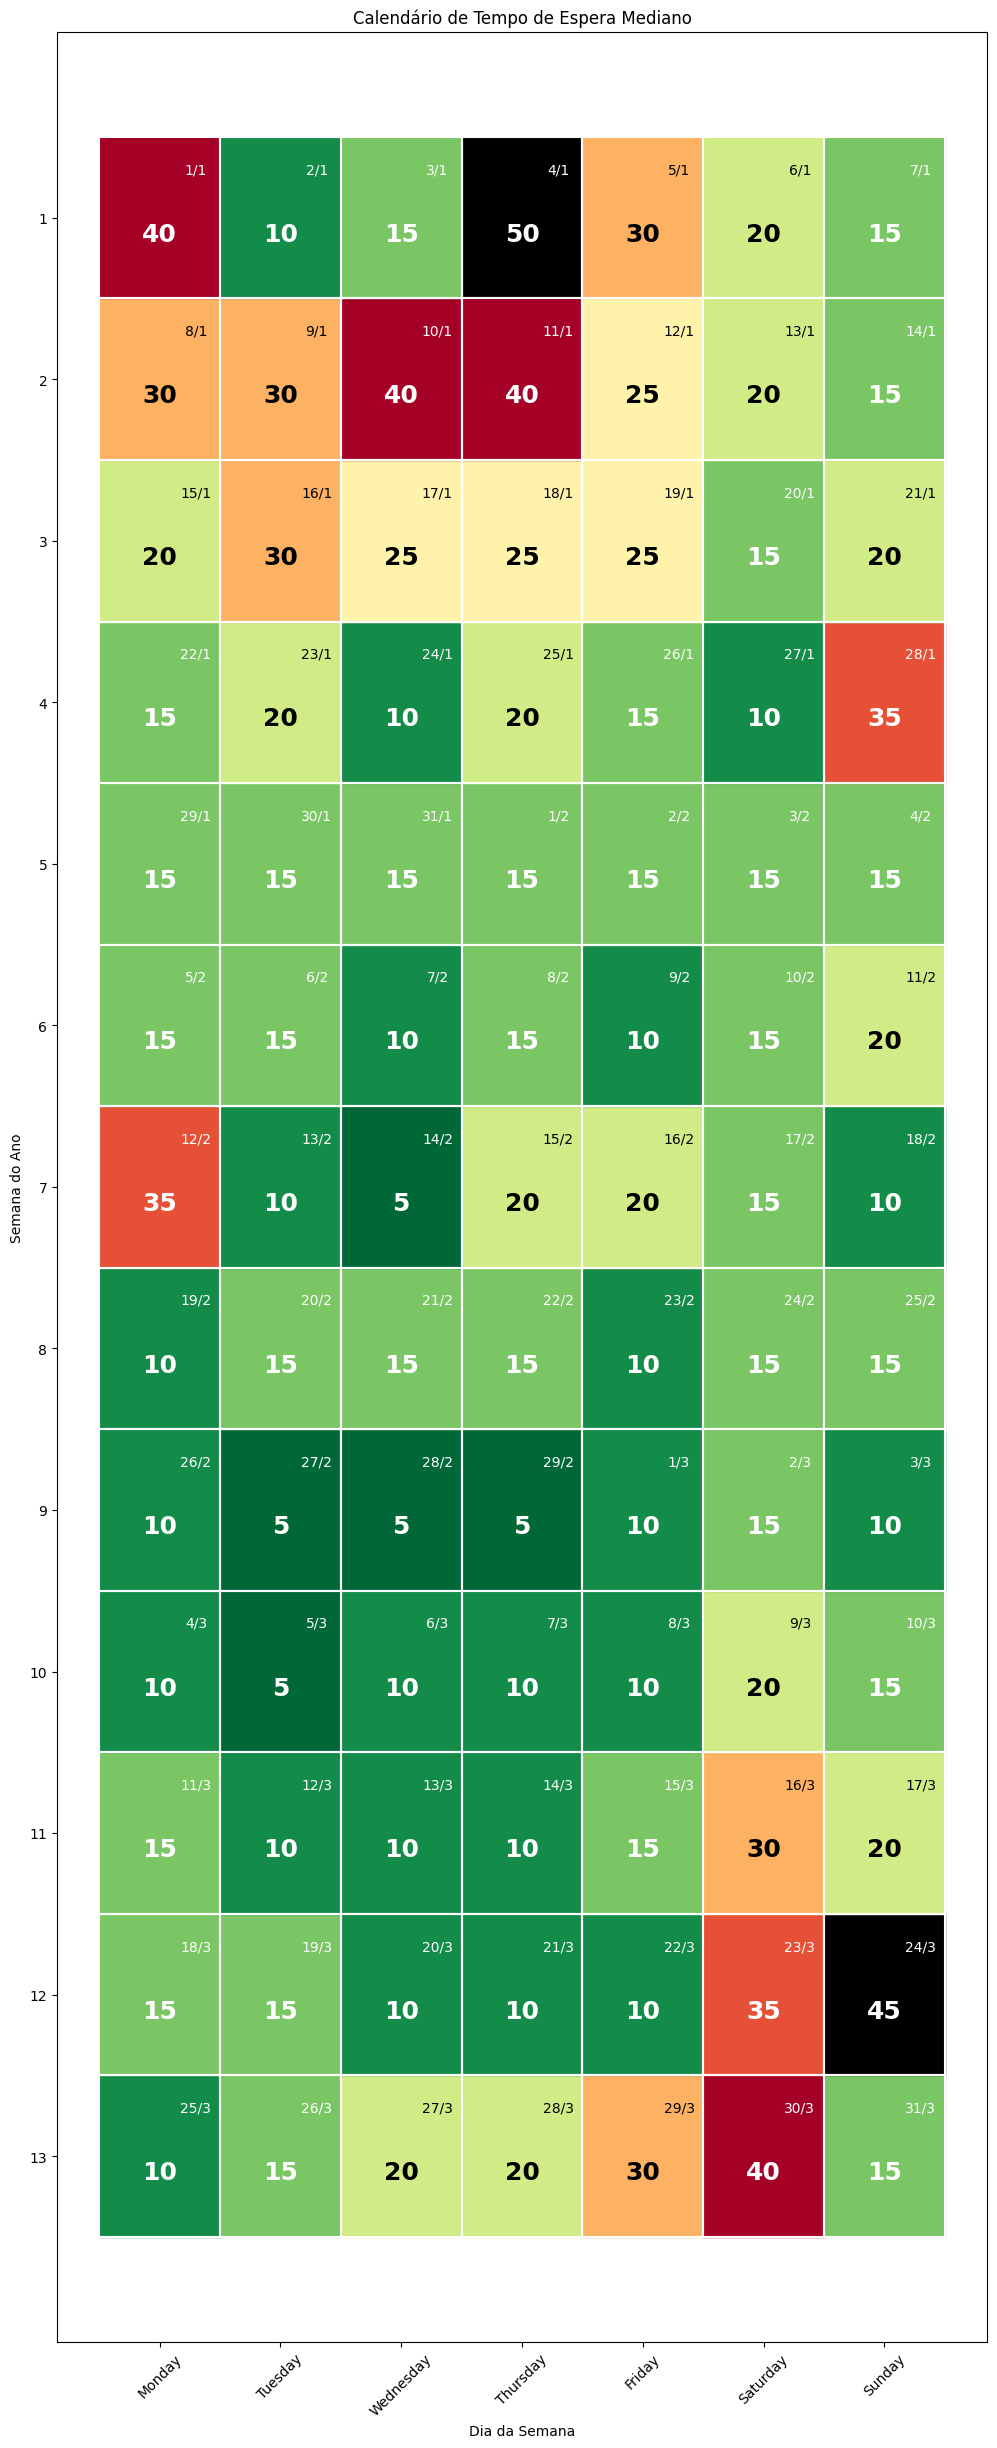

In [38]:
gera_calendario(espera_mediana, 'Anual', 'median', '')

In [39]:
# for mes in meses:
#     numero_mes = meses.index(mes)
#     gera_calendario(espera_mediana_meses[numero_mes], 'Mensal', 'median', mes)

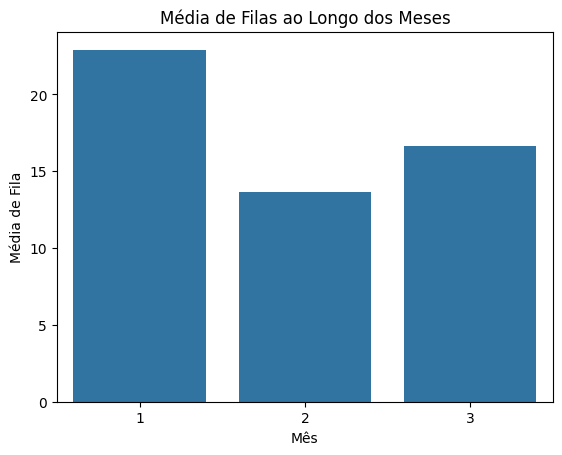

In [40]:
# Média de filas ao longo dos meses
media_mes = espera_mediana.groupby('month')['wait_time'].mean()

# Plotar gráfico de barras
sns.barplot(x=media_mes.index, y=media_mes.values)
plt.xlabel('Mês')
plt.ylabel('Média de Fila')
plt.title('Média de Filas ao Longo dos Meses')
plt.show()

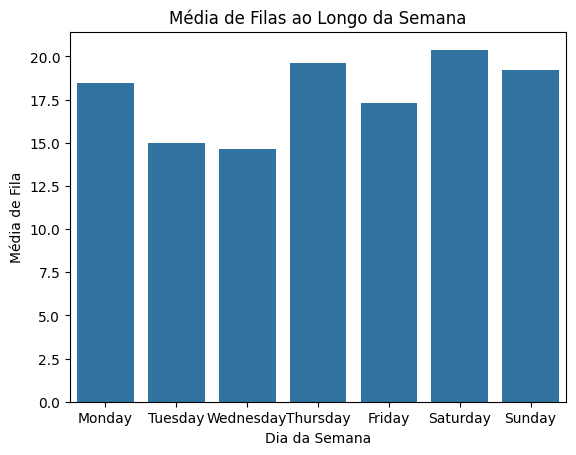

In [41]:
# Média de filas ao longo da semana
media_semana = espera_mediana.groupby('day_of_week')['wait_time'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plotar gráfico de barras
sns.barplot(x=media_semana.index, y=media_semana.values)
plt.xlabel('Dia da Semana')
plt.ylabel('Média de Fila')
plt.title('Média de Filas ao Longo da Semana')
plt.show()

### ANÁLISE BASEADA NA MODA DOS TEMPOS DE FILA

In [42]:
espera_moda = df_geral.groupby('date')['wait_time'].apply(lambda x: x.mode()[0]).reset_index()

In [43]:
espera_moda['wait_time'] = espera_moda['wait_time'].round(0)

In [44]:
espera_moda['date'] = pd.to_datetime(espera_moda['date'])
espera_moda['year'] = espera_moda['date'].dt.year
espera_moda['month'] = espera_moda['date'].dt.month
espera_moda['day'] = espera_moda['date'].dt.day

In [45]:
espera_moda = pd.merge(espera_moda, tabela_horarios, on="date", how="left")

# Adicione colunas para o dia da semana e a semana do ano
espera_moda['day_of_week'] = espera_moda['date'].dt.day_name()
espera_moda['week_of_year'] = espera_moda['date'].dt.isocalendar().week

# Identifique os registros que atendem ao critério
primeiros_dias_janeiro = (espera_moda['month'] == 1) & (espera_moda['week_of_year'] > 50)

# Atribua o valor 0 à coluna 'week_of_year' para esses registros
espera_moda.loc[primeiros_dias_janeiro, 'week_of_year'] = 0

espera_moda

,date,wait_time,year,month,day,day_of_the_week,park_open,park_opening_time,park_closing_time,sale,...,Madagascar 1600,Madagascar 1700,Sonho 1800,Excalibur 1200,Excalibur 1430,Excalibur 1700,Shrek 1900,Trolls 1900,day_of_week,week_of_year
0,2024-01-01,5,2024,1,1,monday,True,10:00:00,19:00:00,NaN,...,True,True,True,True,False,False,True,False,Monday,1
1,2024-01-02,5,2024,1,2,tuesday,True,10:00:00,19:00:00,NaN,...,True,False,True,True,False,False,True,False,Tuesday,1
2,2024-01-03,5,2024,1,3,wednesday,True,10:00:00,19:00:00,NaN,...,True,True,True,True,True,True,True,False,Wednesday,1
3,2024-01-04,15,2024,1,4,thursday,True,10:00:00,19:00:00,NaN,...,True,True,True,True,True,True,True,False,Thursday,1
4,2024-01-05,5,2024,1,5,friday,True,10:00:00,19:00:00,NaN,...,True,True,True,True,True,False,True,False,Friday,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,2024-03-27,5,2024,3,27,wednesday,True,10:00:00,19:00:00,NaN,...,True,False,True,True,False,False,False,True,Wednesday,13
87,2024-03-28,5,2024,3,28,thursday,True,10:00:00,19:00:00,NaN,...,True,False,True,True,False,False,False,True,Thursday,13
88,2024-03-29,30,2024,3,29,friday,True,10:00:00,19:00:00,NaN,...,True,False,True,True,False,False,False,True,Friday,13
89,2024-03-30,10,2024,3,30,saturday,True,10:00:00,19:00:00,NaN,...,True,False,True,True,False,False,False,True,Saturday,13


In [46]:
# Reorganize o dataframe para a forma desejada
pivot_df = espera_moda.pivot_table(values='wait_time', index='week_of_year', columns='day_of_week', aggfunc=np.mean)

# Reordene as colunas para começar na segunda-feira
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_df = pivot_df[ordered_days]

C:\Users\Luis PC\AppData\Local\Temp\ipykernel_9888\2651105031.py:2: FutureWarning: The provided callable <function mean at 0x00000189ACAE5300> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_df = espera_moda.pivot_table(values='wait_time', index='week_of_year', columns='day_of_week', aggfunc=np.mean)


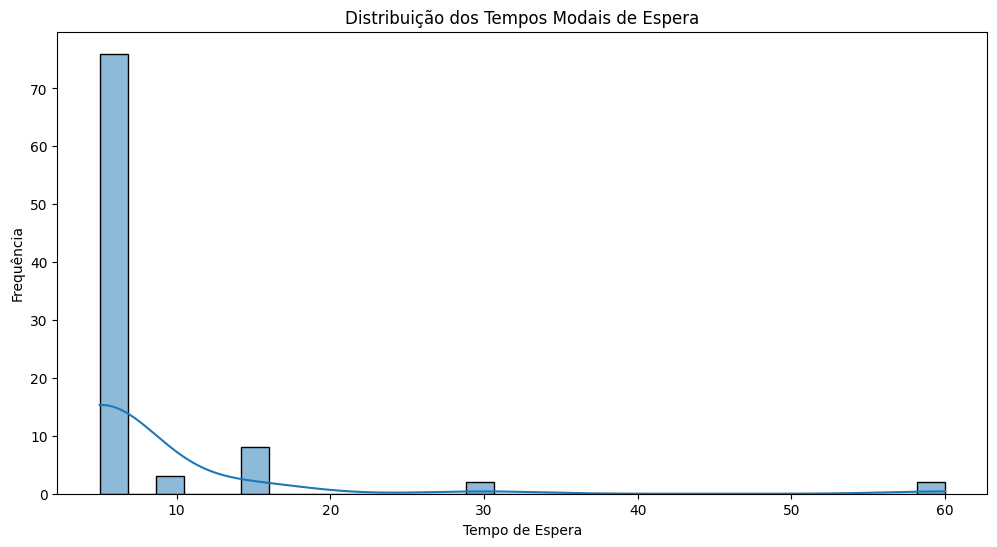

In [47]:
plt.figure(figsize=(12, 6))
sns.histplot(espera_moda['wait_time'], bins=30, kde=True)
plt.title("Distribuição dos Tempos Modais de Espera")
plt.xlabel("Tempo de Espera")
plt.ylabel("Frequência")
plt.show()

In [48]:
meses = ['jan', 'fev', 'mar', 'abr', 'mai', 'jun', 'jul', 'ago', 'set', 'out', 'nov', 'dez']

espera_moda_meses = []

for mes in meses:
    numero_mes = meses.index(mes) + 1  # Obtém o número do mês (janeiro = 1, fevereiro = 2, etc.)
    espera_moda_mes = espera_moda[espera_moda['month'] == numero_mes]
    espera_moda_meses.append(espera_moda_mes)

In [49]:
# Cálculo dos percentis
p5 = np.percentile(espera_moda['wait_time'], 5)
p90 = np.percentile(espera_moda['wait_time'], 90)
p95 = np.percentile(espera_moda['wait_time'], 95)

C:\Users\Luis PC\AppData\Local\Temp\ipykernel_9888\2413875904.py:16: FutureWarning: The provided callable <function mean at 0x00000189ACAE5300> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_df = espera.pivot_table(values='wait_time', index='week_of_year', columns='day_of_week', aggfunc=np.mean)


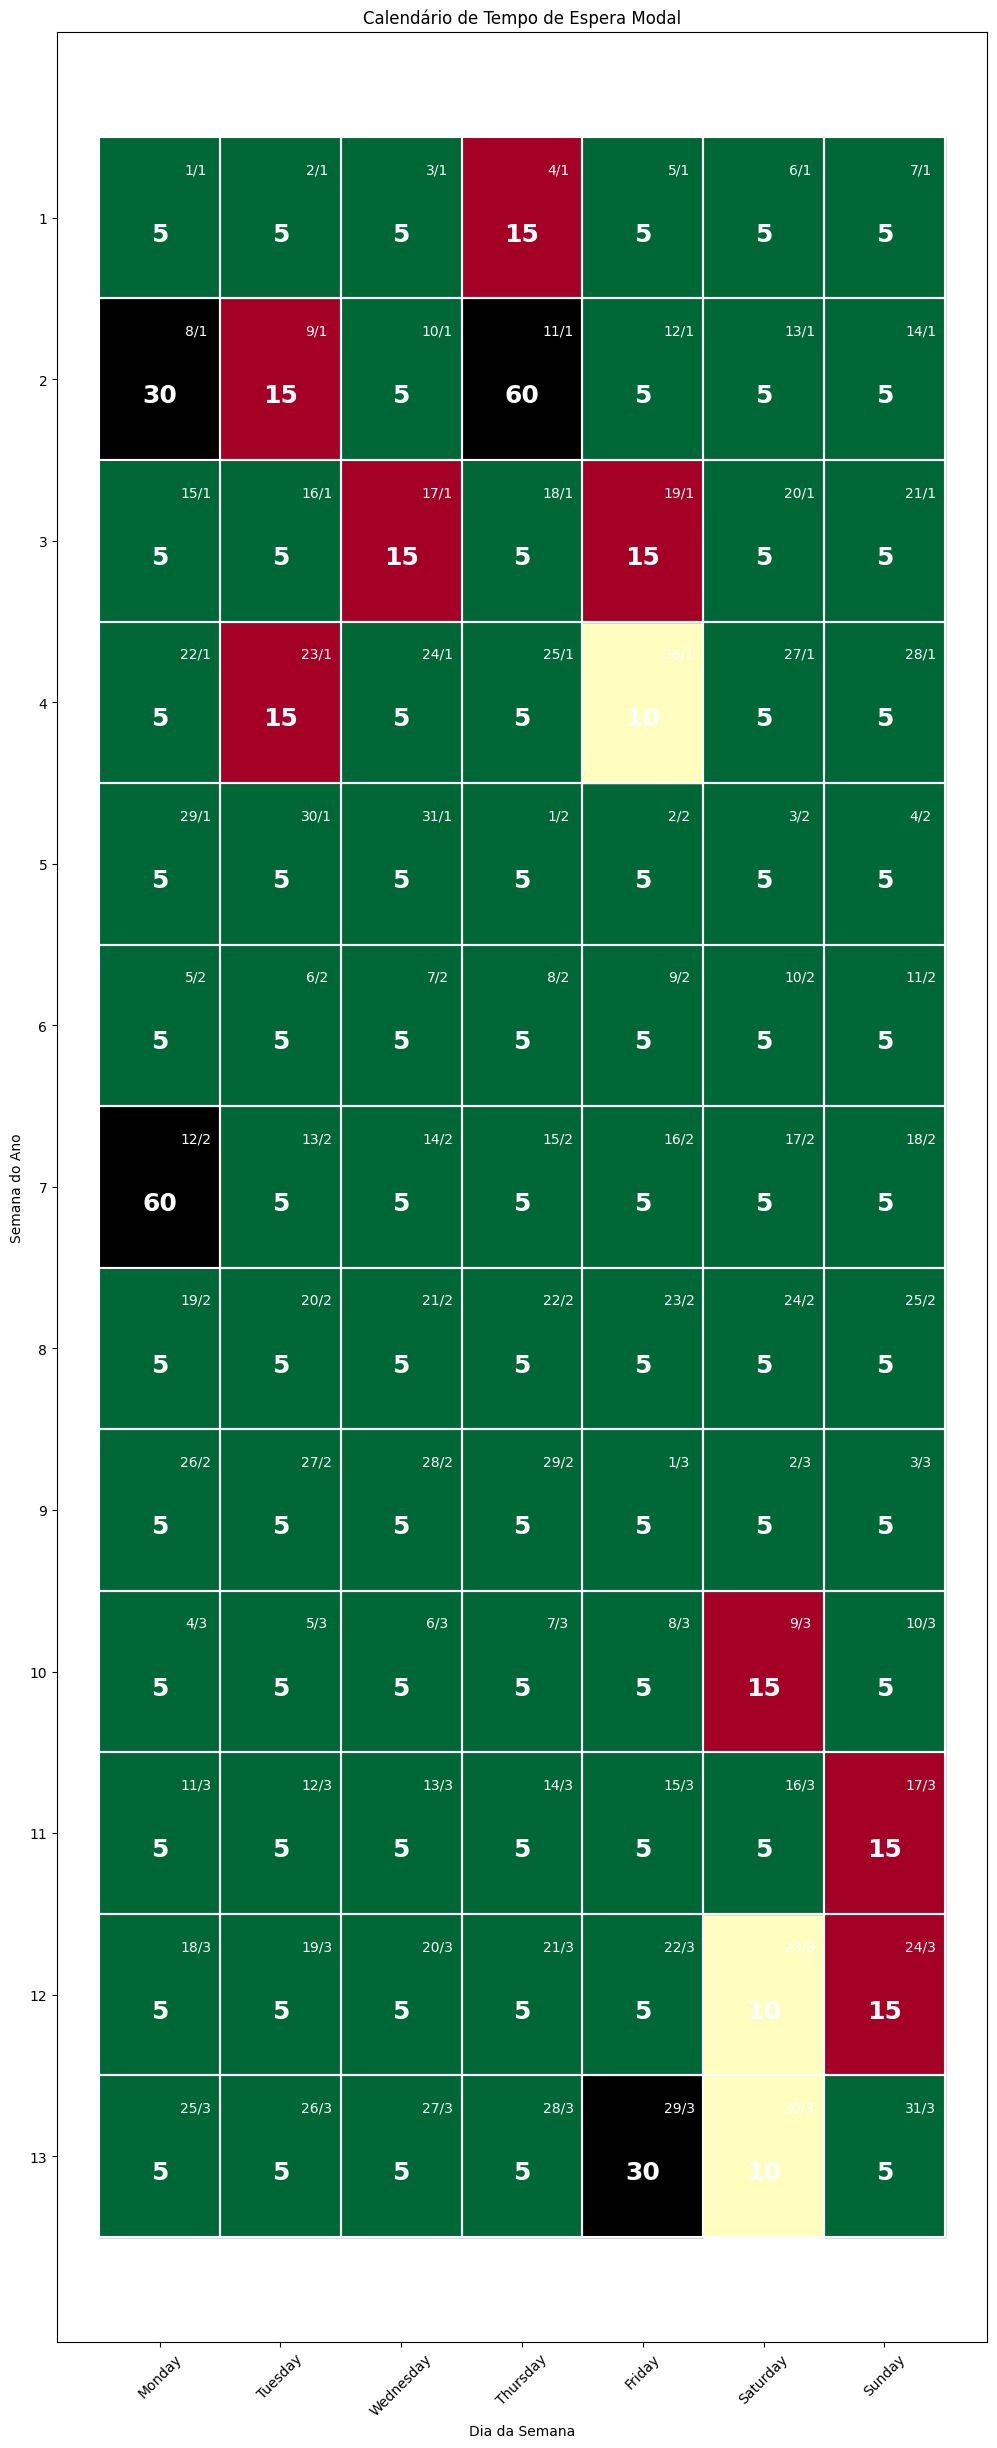

In [50]:
gera_calendario(espera_moda, 'Anual', 'mode', '')

In [51]:
# for mes in meses:
#     numero_mes = meses.index(mes)
#     gera_calendario(espera_moda_meses[numero_mes], 'Mensal', 'mode', mes)

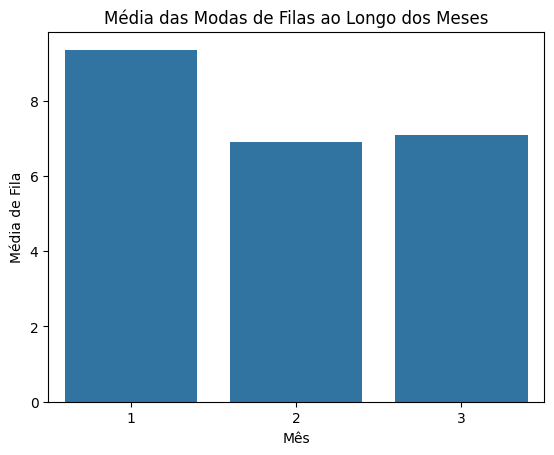

In [52]:
# Média de filas ao longo dos meses
media_mes = espera_moda.groupby('month')['wait_time'].mean()

# Plotar gráfico de barras
sns.barplot(x=media_mes.index, y=media_mes.values)
plt.xlabel('Mês')
plt.ylabel('Média de Fila')
plt.title('Média das Modas de Filas ao Longo dos Meses')
plt.show()

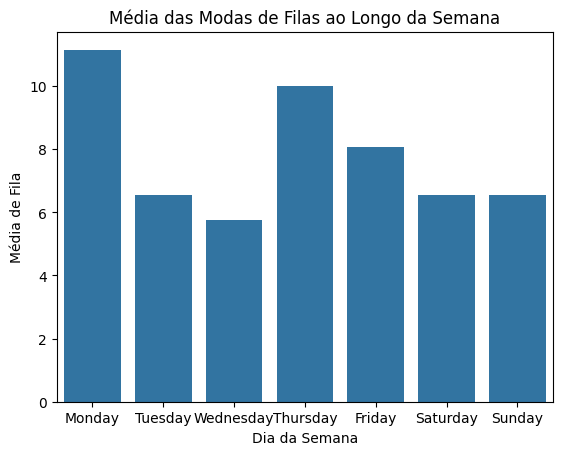

In [53]:
# Média de filas ao longo da semana
media_semana = espera_moda.groupby('day_of_week')['wait_time'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plotar gráfico de barras
sns.barplot(x=media_semana.index, y=media_semana.values)
plt.xlabel('Dia da Semana')
plt.ylabel('Média de Fila')
plt.title('Média das Modas de Filas ao Longo da Semana')
plt.show()

### ANÁLISE BASEADA NO DESVIO PADRÃO DIÁRIO

In [54]:
espera_dp = df_geral.groupby('date')['wait_time'].std().reset_index()

In [55]:
espera_dp['wait_time'] = espera_dp['wait_time'].round(0)

In [56]:
espera_dp['date'] = pd.to_datetime(espera_dp['date'])
espera_dp['year'] = espera_dp['date'].dt.year
espera_dp['month'] = espera_dp['date'].dt.month
espera_dp['day'] = espera_dp['date'].dt.day

In [57]:
espera_dp = pd.merge(espera_dp, tabela_horarios, on="date", how="left")

# Adicione colunas para o dia da semana e a semana do ano
espera_dp['day_of_week'] = espera_dp['date'].dt.day_name()
espera_dp['week_of_year'] = espera_dp['date'].dt.isocalendar().week

# Identifique os registros que atendem ao critério
primeiros_dias_janeiro = (espera_dp['month'] == 1) & (espera_dp['week_of_year'] > 50)

# Atribua o valor 0 à coluna 'week_of_year' para esses registros
espera_dp.loc[primeiros_dias_janeiro, 'week_of_year'] = 0

espera_dp

,date,wait_time,year,month,day,day_of_the_week,park_open,park_opening_time,park_closing_time,sale,...,Madagascar 1600,Madagascar 1700,Sonho 1800,Excalibur 1200,Excalibur 1430,Excalibur 1700,Shrek 1900,Trolls 1900,day_of_week,week_of_year
0,2024-01-01,40.0,2024,1,1,monday,True,10:00:00,19:00:00,NaN,...,True,True,True,True,False,False,True,False,Monday,1
1,2024-01-02,19.0,2024,1,2,tuesday,True,10:00:00,19:00:00,NaN,...,True,False,True,True,False,False,True,False,Tuesday,1
2,2024-01-03,20.0,2024,1,3,wednesday,True,10:00:00,19:00:00,NaN,...,True,True,True,True,True,True,True,False,Wednesday,1
3,2024-01-04,51.0,2024,1,4,thursday,True,10:00:00,19:00:00,NaN,...,True,True,True,True,True,True,True,False,Thursday,1
4,2024-01-05,42.0,2024,1,5,friday,True,10:00:00,19:00:00,NaN,...,True,True,True,True,True,False,True,False,Friday,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,2024-03-27,25.0,2024,3,27,wednesday,True,10:00:00,19:00:00,NaN,...,True,False,True,True,False,False,False,True,Wednesday,13
87,2024-03-28,31.0,2024,3,28,thursday,True,10:00:00,19:00:00,NaN,...,True,False,True,True,False,False,False,True,Thursday,13
88,2024-03-29,43.0,2024,3,29,friday,True,10:00:00,19:00:00,NaN,...,True,False,True,True,False,False,False,True,Friday,13
89,2024-03-30,47.0,2024,3,30,saturday,True,10:00:00,19:00:00,NaN,...,True,False,True,True,False,False,False,True,Saturday,13


In [58]:
# Reorganize o dataframe para a forma desejada
pivot_df = espera_dp.pivot_table(values='wait_time', index='week_of_year', columns='day_of_week', aggfunc=np.mean)

# Reordene as colunas para começar na segunda-feira
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_df = pivot_df[ordered_days]

C:\Users\Luis PC\AppData\Local\Temp\ipykernel_9888\471606904.py:2: FutureWarning: The provided callable <function mean at 0x00000189ACAE5300> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_df = espera_dp.pivot_table(values='wait_time', index='week_of_year', columns='day_of_week', aggfunc=np.mean)


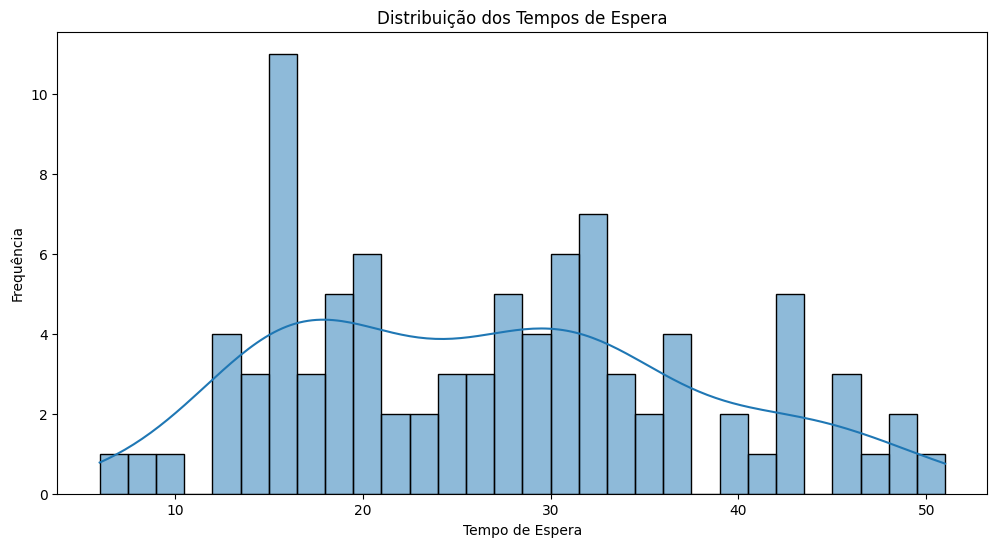

In [59]:
plt.figure(figsize=(12, 6))
sns.histplot(espera_dp['wait_time'], bins=30, kde=True)
plt.title("Distribuição dos Tempos de Espera")
plt.xlabel("Tempo de Espera")
plt.ylabel("Frequência")
plt.show()

In [60]:
meses = ['jan', 'fev', 'mar', 'abr', 'mai', 'jun', 'jul', 'ago', 'set', 'out', 'nov', 'dez']

espera_std_meses = []

for mes in meses:
    numero_mes = meses.index(mes) + 1  # Obtém o número do mês (janeiro = 1, fevereiro = 2, etc.)
    espera_std_mes = espera_media[espera_dp['month'] == numero_mes]
    espera_std_meses.append(espera_std_mes)

In [61]:
# Cálculo dos percentis
p5 = np.percentile(espera_dp['wait_time'], 5)
p90 = np.percentile(espera_dp['wait_time'], 90)
p95 = np.percentile(espera_dp['wait_time'], 95)

C:\Users\Luis PC\AppData\Local\Temp\ipykernel_9888\2413875904.py:16: FutureWarning: The provided callable <function mean at 0x00000189ACAE5300> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_df = espera.pivot_table(values='wait_time', index='week_of_year', columns='day_of_week', aggfunc=np.mean)


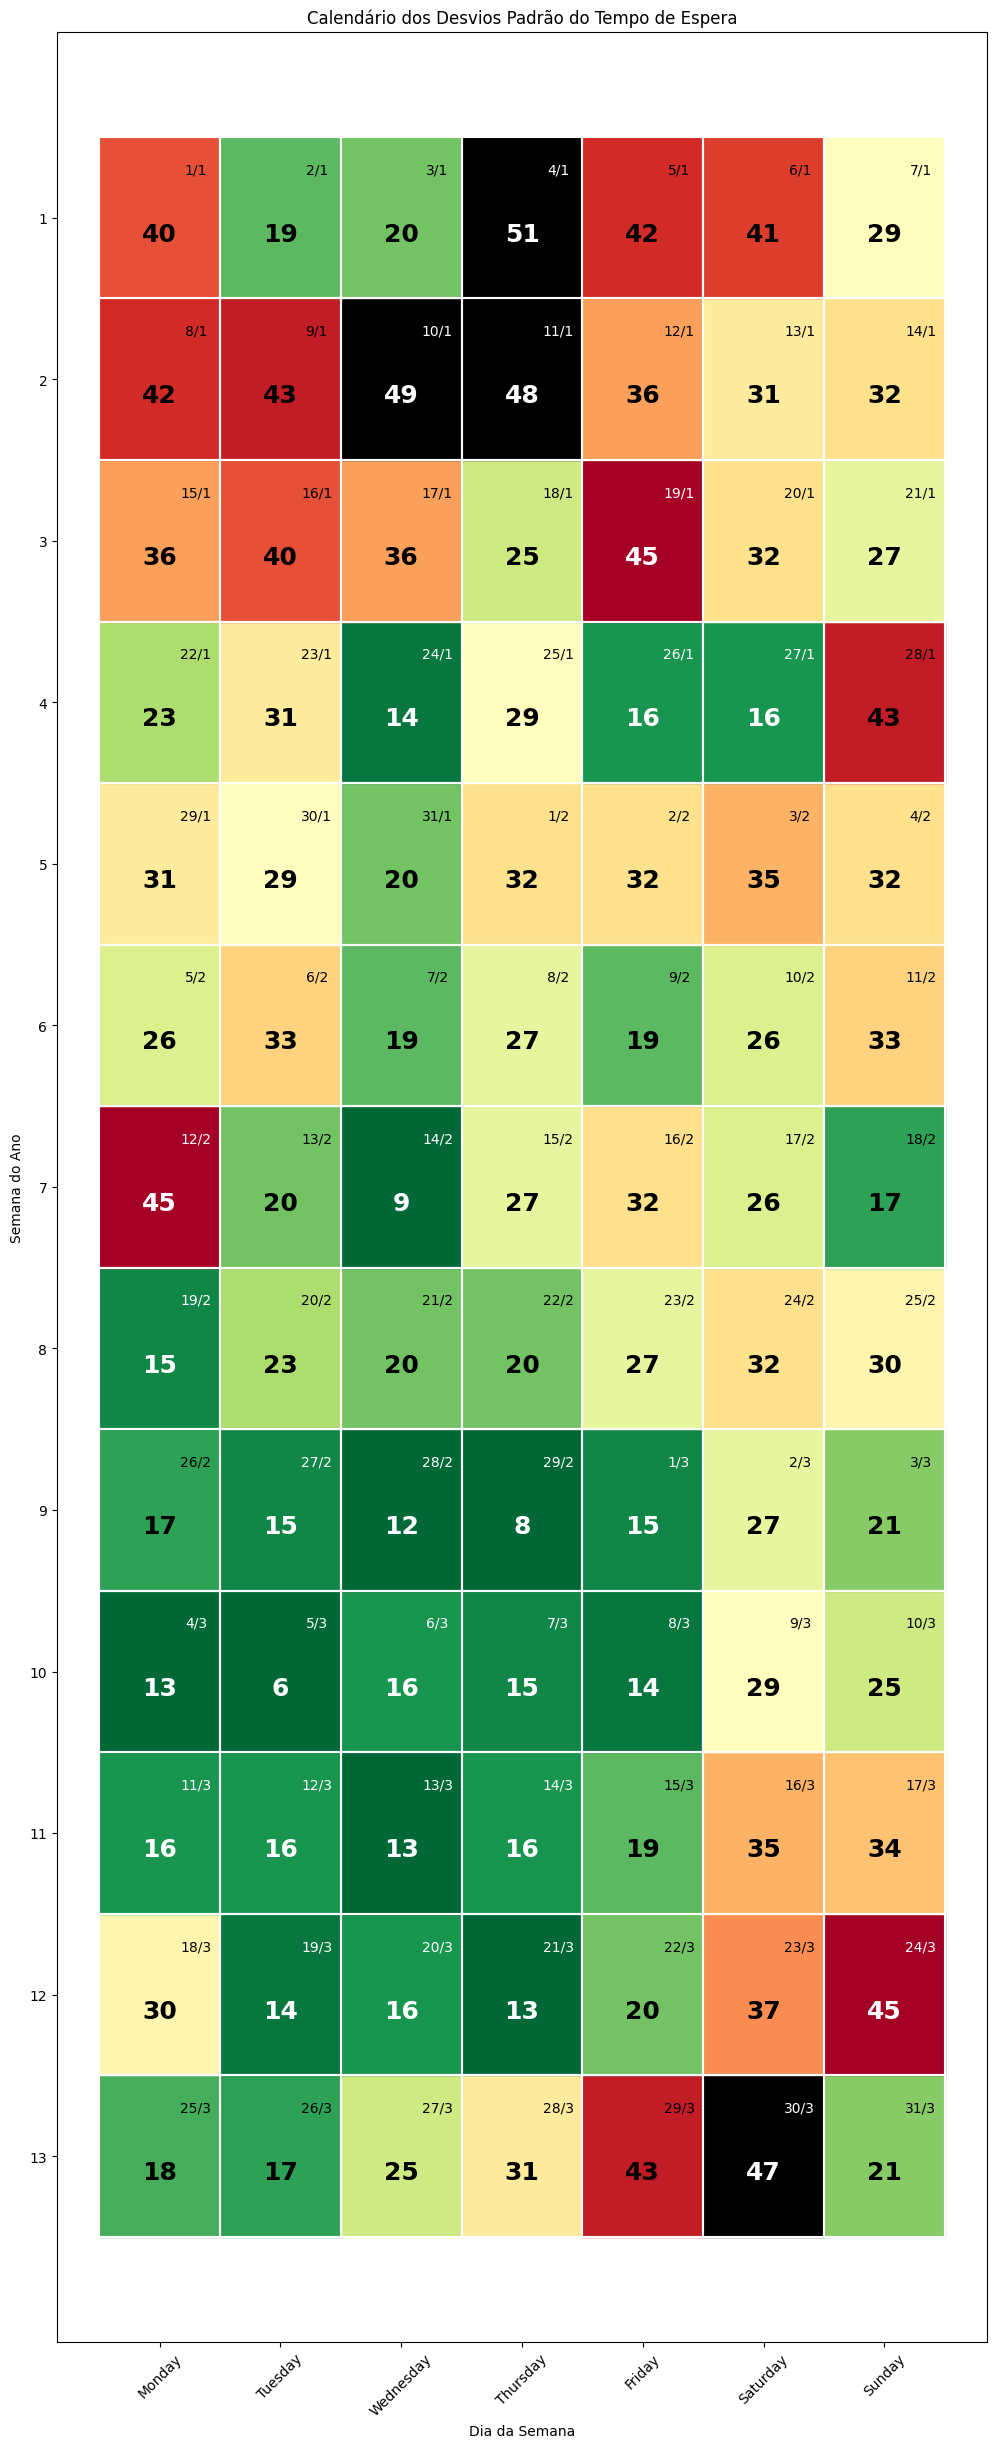

In [62]:
gera_calendario(espera_dp, 'Anual', 'std', '')

In [63]:
# for mes in meses:
#     numero_mes = meses.index(mes)
#     gera_calendario(espera_std_meses[numero_mes], 'Mensal', 'std', mes)

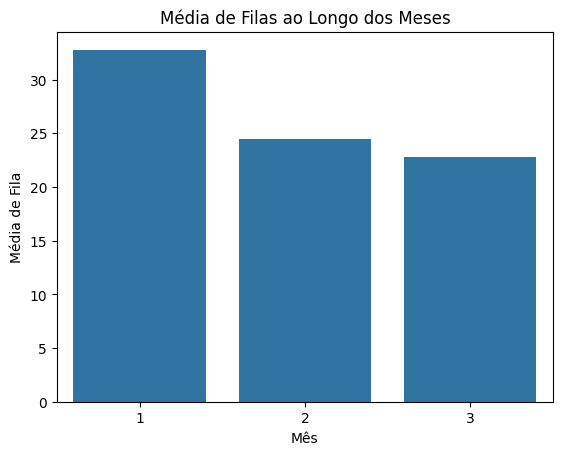

In [64]:
# Média de filas ao longo dos meses
media_mes = espera_dp.groupby('month')['wait_time'].mean()

# Plotar gráfico de barras
sns.barplot(x=media_mes.index, y=media_mes.values)
plt.xlabel('Mês')
plt.ylabel('Média de Fila')
plt.title('Média de Filas ao Longo dos Meses')
plt.show()

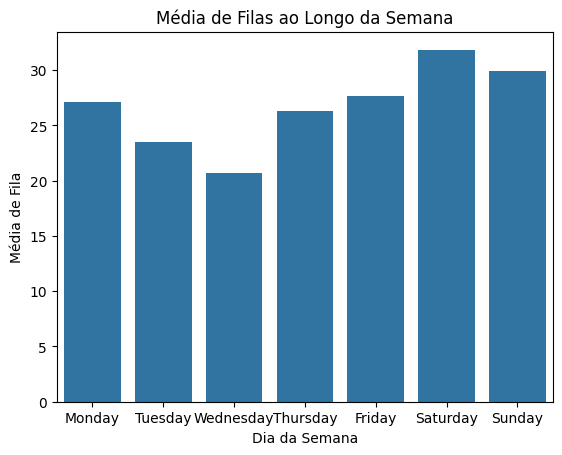

In [65]:
# Média de filas ao longo da semana
media_semana = espera_dp.groupby('day_of_week')['wait_time'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plotar gráfico de barras
sns.barplot(x=media_semana.index, y=media_semana.values)
plt.xlabel('Dia da Semana')
plt.ylabel('Média de Fila')
plt.title('Média de Filas ao Longo da Semana')
plt.show()